In [152]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
import scipy
import matplotlib.patches as patches
import pandas as pd
from scipy.io import readsav
from regions import Regions #read_ds9, write_ds9
import csv
import math
from scipy.optimize import curve_fit
import time
from pathlib import Path
from pyds9 import ds9
from scipy.integrate import quad
from astropy.table import QTable, Table, Column, vstack
from astropy.visualization.stretch import AsinhStretch
from astropy.visualization import ImageNormalize, simple_norm
import matplotlib.patches as patches

In [3]:
hdr = fits.getheader('ISF_Mosaic_Trial5_drz_sci.fits')
im  = fits.getdata('ISF_Mosaic_Trial5_drz_sci.fits')
wcs = WCS(hdr)

In [4]:
def write_regf(ra, dec, fname, c, text, r=None, update=False):
    """
    fname - file name to be written
    c - region color
    """
    xx, yy = ra, dec
    text = np.array(text, dtype=str)
    if r==None:
        r =25
    else:
        r=r
    if update == True:
        with open(fname) as unt:
            lines = unt.readlines()
        with open(fname, 'w') as unt:    
            unt.writelines(lines)

            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')
    else:
        with open(fname, 'w') as unt:
            unt.write('fk5')
            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')

In [5]:
def norm_logistic_reg(x, mu, sig):
    w = 1/(1+np.exp(-((x-mu)/sig)))
    return w

In [6]:
def r_times_logistic_reg(x, m, s):
    w = x/(1+np.exp(-((x-m)/s)))
    return w

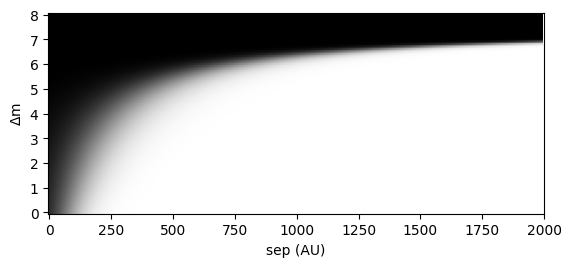

In [7]:
frac_mtx = np.loadtxt('Fraction_dm_sep_array.txt')
fig, ax = plt.subplots()
plt.imshow(frac_mtx, origin='lower', cmap='gray')
locs = plt.xticks()
plt.xticks(locs[0][1::], np.arange(0, 2001, 250))
locs = plt.yticks()
plt.yticks(locs[0][1:-1], np.arange(0, 9, 1))
plt.xlabel('sep (AU)')
plt.ylabel('$\Delta$m');

In [8]:
df_params = pd.read_csv('mu_sig_params.csv')
mu, sig = np.array(df_params['mu']), np.array(df_params['sig'])
df_flame = pd.read_csv('dm_sep_flame.csv')
sep_flame, dm_flame = np.array(df_flame['sep']), np.array(df_flame['dm'])

In [316]:
df_final = pd.read_csv('dash_rereduce_removed_combined_with_rereduceII_with_VISION.csv')
df_final2 = df_final
ra_f2 = np.array(df_final2['RA_d'])
dec_f2 = np.array(df_final2['DEC_d'])
m_f2 = np.array(df_final2['MAG_d'])
me_f2 = np.array(df_final2['MAG_d_unc'])
h_f2 = np.array(df_final2['H_v'])
he_f2 = np.array(df_final2['He_v'])
k_f2 = np.array(df_final2['Ks_v'])
ke_f2 = np.array(df_final2['Kse_v'])
fwhm_f2 = np.array(df_final2['FWHM_d'])
rsat_f2 = np.array(df_final2['R_SAT_d'])
clas_f2 = np.array(df_final2['class'], dtype=str)

yso_clas = np.array(['protostars', 'disks', 'td', 'nd_proto_faint'])
proto_clas = np.array(['protostars', 'nd_proto_faint'])
prems_clas = np.array(['disks', 'td'])

i_yso, = np.where(np.isin(clas_f2, yso_clas))
i_proto, = np.where(np.isin(clas_f2, proto_clas))
i_prems, = np.where(np.isin(clas_f2, prems_clas))

In [311]:
write_regf(ra_f2[np.isfinite(ra_f2)], dec_f2[np.isfinite(ra_f2)], 'Final_Catalog.reg', 'green', [])

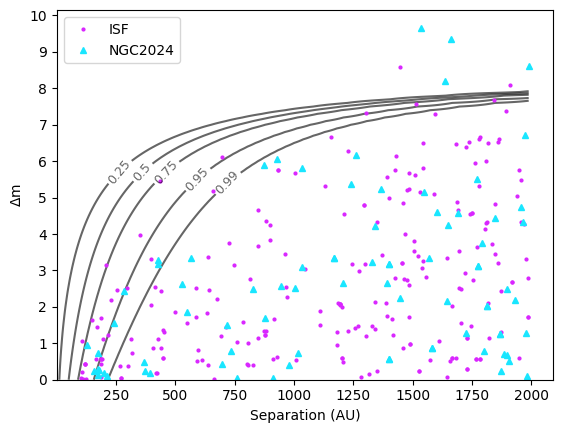

In [10]:
dms = np.arange(0, 8.01, 1/10)
seps = np.arange(50, 2050., 100/10)
dm_mtx, sep_mtx = np.indices((len(dms), len(seps)))
#sep_mtx = np.tile(np.arange(0, 2000.1, 0.1), )
dm_mtx, sep_mtx = (np.flip(dm_mtx,0))/10, 100*(sep_mtx+5)/10
frac_mtx = np.zeros(dm_mtx.shape)
n_dm = len(dms)
for i in range(len(mu)):
    frac_mtx[i, :] =  norm_logistic_reg(seps, mu[i], sig[i])

cmap = plt.cm.cool
category_colors = plt.colormaps['cool'](
        np.linspace(0.10, 0.85, 6))

fig, ax = plt.subplots()
#plt.imshow(frac_mtx, origin='lower', cmap='Greys_r', aspect="auto")
#colors=[category_colors[0]]

c25 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.25], colors='k', alpha=0.6)
c50 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.50], colors='k', alpha=0.6)
c75 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.75], colors='k', alpha=0.6)
c95 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.95], colors='k', alpha=0.6)
c99 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.99], colors='k', alpha=0.6)

xt = ax.get_xticks()
ax.set_xticks(xt[1::], np.round(xt[1::]*100/10).astype(int))
yt = ax.get_yticks()
ax.set_yticks(yt[1:-1], np.round((yt[1:-1])/10).astype(int))

manual_locations = [(20, 60)]
plt.clabel(c25, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(30, 60)]
plt.clabel(c50, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(40, 60)]
plt.clabel(c75, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(50, 60)]
plt.clabel(c95, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(60, 60)]
plt.clabel(c99, fontsize=9, inline=1, manual=manual_locations)

ax.set_xlabel('Separation (AU)')
ax.set_ylabel('$\Delta$m')


ra_cat, dec_cat, m_cat, i_yso = ra_f2, dec_f2, m_f2, i_yso
N_total = len(i_yso)
N_cand, N_cont = 0, 0
r1_comp = 100
r2_comp = 2000
r1_cont = 2000
r2_cont = 5000

#Making a catalog object using all sources
c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
              distance=390.*u.pc, frame='fk5')

ra_yso  = ra_cat[i_yso]
dec_yso = dec_cat[i_yso]
m_yso   = m_cat[i_yso]

i_tested = np.array([])
N_cand   = np.array([])

d_comp = np.array([])
dm_comp = np.array([])

for i in range(N_total):
    #Making a catalog object using YSO
    c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
    sep_     = c2.separation(c1).arcsec*400.
    i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
    n_obj    = len(i_obj_)

    if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
        ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
        dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
        m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array

        i_prim, = np.where(m_sys==np.min(m_sys))
        i_comp, = np.where(m_sys!=np.min(m_sys))
        N_cand  = N_cand + len(i_comp)
        ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
        ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
        m_prim = m_sys[i_prim]
        c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')

        c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
        sep_comp = c_comp.separation(c_prim).arcsec*400.
        #ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
        d_comp = np.append(d_comp, sep_comp)
        dm_comp = np.append(dm_comp, np.abs((m_sys[i_comp]-m_prim)))
ax.plot(d_comp/10, dm_comp*10, '.', c=category_colors[5], ms=4, label='ISF')
ax.plot(sep_flame/10, dm_flame*10, '^', c=category_colors[0], ms=4, label='NGC2024')
#ax.set_ylim(0, 100)
#ax.set_yticks(np.arange(0, 11, 1))
#yticks = ax.get_yticks()

ax.set_yticks(np.arange(0, 110, 10), np.arange(0, 11, 1));
ax.legend()

In [312]:
def CF(ra_cat, dec_cat, m_cat, i_yso):
    N_total = len(i_yso) #Total number of YSOs
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=400.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R     = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    N_cont  = 0
    d_mag   = np.array([])
    dist    = np.array([])
    #fig, ax = plt.subplots()
    
    for i in range(N_total):
        #Making a catalog object using the ith YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*400.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp))#&(m_cat>10.5))
        n_obj    = len(i_obj_)
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            if len(i_tested)==0:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=False)
            else:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=True)
            
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
            ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
            m_prim = m_sys[i_prim]
            c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')
            c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
            sep_comp = c_comp.separation(c_prim).arcsec*400.
            
            #making a new cat obj with the dimmest objects in the system
            #n_obj is recalculated using the "new" primary.
            sep      = c2.separation(c_prim).arcsec*400.
            i_obj_,  = np.where((sep>=r1_comp)&(sep<=r2_comp))#&(m_cat>10.5))
            n_obj    = len(i_obj_)
            N_cand   = N_cand + n_obj
            
            i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
        else:
            m_prim   = m_yso[i]
            i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
        
        N_cont_init = np.append(N_cont_init, len(i_cont))
        n_cont = 0
        if len(i_cont)>0: #N_contaminants is calculated around all YSOs in the region.
            for j in range(len(i_cont)):
                delta_m = m_cat[i_cont[j]]-m_prim
                dm_ind  = int(np.abs(10*np.round(delta_m, 1)))
                if dm_ind>80: #80: delta_mag=8
                    mu_, sig_ = 0, 0
                    R_ = 0
                else:
                    mu_  = mu[dm_ind]
                    sig_ = sig[dm_ind]
                    I  = quad(r_times_logistic_reg, r1_comp, r2_comp, args=(mu_, sig_))
                    R_ = 2*np.pi * I[0] / (np.pi*(r2_cont**2 - r1_cont**2))
                    R  = np.append(R, R_)
                    d_mag=np.append(d_mag,dm_ind)
                    R_unc   = np.append(R_unc, I[1])
                    dist = np.append(dist, sep_[i_cont[j]])
                n_cont  = n_cont + R_
                
            N_cont_corr = np.append(N_cont_corr, n_cont)
            N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                          len(i_cont)*
                                          (r2_comp**2-r1_comp**2)/(r2_cont**2-r1_cont**2))
            N_cont = N_cont + n_cont

        i_tested = np.append(i_tested, i_yso[i])
        i_tested = np.append(i_tested, i_obj_)
    N_comp   = N_cand - N_cont
        

    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    #for i in range(len(dist)):
    #    ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(100*np.round(R[i], 3))])           
    #ax.plot(R, '.r')
    print('N_cand: ', N_cand)
    print('N_cont within 200-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 200-5000: ', np.sum(N_cont_corr))
    print('N_contaminants: ', np.sum(N_cont_init))
    print('N_comp: ', N_comp)
    print('CF ('+str(N_total)+'): ', N_comp/N_total)
    return d_mag, R, dist

In [313]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_yso)

N_cand:  92
N_cont within 200-5000 (before correction):  40.307142857142864
N_cont within 200-5000:  33.80059972203079
N_contaminants:  855.0
N_comp:  58.19940027796918
CF (671):  0.08673532083154871


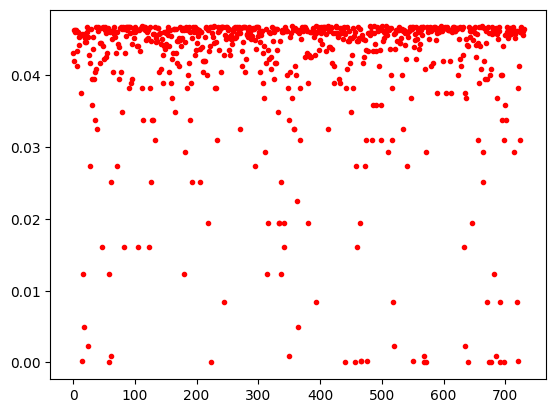

In [118]:
plt.subplot()
plt.plot(R, '.r')

In [20]:
854*0.047

40.138

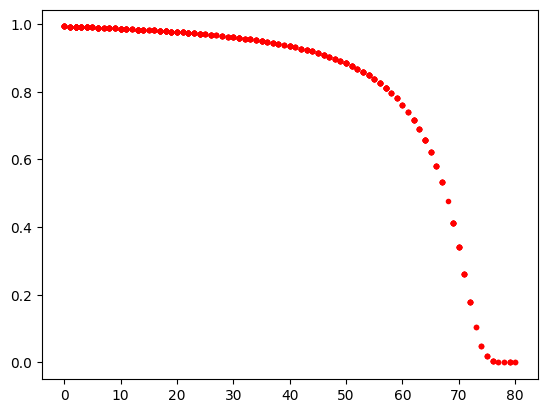

In [121]:
plt.subplot()
plt.plot(dmag, R/(1000**2-100**2)*(5000**2-2000**2), '.r')

--------------


## Testing calculations with Guided Survey

In [297]:
def CF_G(ra_cat, dec_cat, m_cat, i_yso):
#ra_cat, dec_cat, m_cat, i_yso = ra_Dcat, dec_Dcat, m_Dcat, i_Dyso
    N_total = len(i_yso)
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=420.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R     = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    N_cont  = 0
    d_mag   = np.array([])
    dist    = np.array([])
    #fig, ax = plt.subplots()
    for i in range(N_total):
        #Making a catalog object using YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=420.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*420.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp))#&(m_cat>10.5))
        n_obj    = len(i_obj_)
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
            ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
            m_prim = m_sys[i_prim]
            c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=420.*u.pc, frame='fk5')
            c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=420.*u.pc, frame='fk5')
            sep_comp = c_comp.separation(c_prim).arcsec*420.
            
            #making a new cat obj with the dimmest objects in the system
            sep      = c2.separation(c_prim).arcsec*420.
            i_obj_,  = np.where((sep>=r1_comp)&(sep<=r2_comp))#&(m_cat>10.5))
            n_obj    = len(i_obj_)
            N_cand   = N_cand + n_obj
            
            i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
        else:
            i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
        
        N_cont_init = np.append(N_cont_init, len(i_cont))
        n_cont = 0
        if len(i_cont)>0:
            for j in range(len(i_cont)):
                delta_m = m_cat[i_cont[j]]-m_prim
                dm_ind  = int(np.abs(10*np.round(delta_m, 1)))
                if dm_ind>80:
                    mu_, sig_ = 0, 0
                    R_ = 0
                else:
                    mu_  = mu[dm_ind]
                    sig_ = sig[dm_ind]
                    I  = quad(r_times_logistic_reg, r1_comp, r2_comp, args=(mu_, sig_))
                    R_ = 2*np.pi * I[0] / (np.pi*(r2_cont**2 - r1_cont**2))
                    R  = np.append(R, R_)
                    d_mag=np.append(d_mag,dm_ind)
                    R_unc   = np.append(R_unc, I[1])
                    dist = np.append(dist, sep_[i_cont[j]])
                n_cont  = n_cont + R_
                
            N_cont_corr = np.append(N_cont_corr, n_cont)
            N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                          len(i_cont)*
                                          (r2_comp**2-r1_comp**2)/(r2_cont**2-r1_cont**2))
            N_cont = N_cont + n_cont

        i_tested = np.append(i_tested, i_yso[i])
        i_tested = np.append(i_tested, i_obj_)
    N_comp   = N_cand - N_cont
        

    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    #for i in range(len(dist)):
    #    ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(1000*np.round(R[i], 3))])           
    #ax.plot(R, '.r')
    print('N_cand: ', N_cand)
    print('N_cont within 2000-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 2000-5000: ', np.sum(N_cont_corr))
    print('N_contaminants: ', np.sum(N_cont_init))
    print('N_comp: ', N_comp-N_cont)
    print('CF ('+str(N_total)+'): ', N_comp/N_total)
    return d_mag, R, dist

In [22]:
guided =  Table.read('wfc3.txt', format='ascii')

In [23]:
catalog = guided[guided['wfc3m']!=-0.0]
catalog

ra,dec,wfc3m,wfc3u,nic1.6m,nic1.6u,nic2.05m,nic2.05u,irtfm,irtfu,hops,separation,closesthops,4thnearest
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
88.737286,1.7155785,13.502162,0.041815419,0.0,0.0,0.0,0.0,10.042865,0.0069383709,3.0,0.0,3.0,226262.17
83.867269,-5.1705367,10.153605,0.047382092,0.0,0.0,0.0,0.0,8.5100002,0.0099999998,-1041.0,0.0,-1041.0,11024.07
83.867387,-5.1700753,13.109348,0.048968194,0.0,0.0,0.0,0.0,11.7,0.1,0.0,720.02943,-1041.0,0.0
83.856884,-5.1325495,10.777232,0.027959219,10.489038,0.001,10.214037,0.001,10.07,0.1,0.0,450.22175,71.0,0.0
83.856605,-5.1326541,18.24376,0.23583913,20.456038,0.0020000001,14.572037,0.0020000001,10.2,0.2,71.0,0.0,71.0,16048.257
83.856402,-5.1324409,12.709577,0.029863019,12.474038,0.0020000001,12.162037,0.0020000001,11.35,0.0033656652,0.0,445.27254,71.0,0.0
83.843163,-5.1275248,12.262151,0.030911366,0.0,0.0,0.0,0.0,8.3172455,0.003998179,-1053.0,0.0,-1053.0,18873.717
84.680734,-7.0263693,12.645921,0.033995372,0.0,0.0,0.0,0.0,10.0,0.1,0.0,302.028,-1131.0,0.0
84.680539,-7.0263264,13.060127,0.034622159,0.0,0.0,0.0,0.0,9.4700003,0.2,-1131.0,0.0,-1131.0,18026.508


In [27]:
#Pre-MS hops<0
#Protostar hops>0
#
c_prems = catalog[(catalog['hops']<0)]
c_proto = catalog[(catalog['hops']>0)]
c_protocand = catalog[(catalog['separation']<1000.)&(catalog['separation']>100.)&(catalog['closesthops']>0.)
        &(catalog['hops']==0.)]
c_premscand = catalog[(catalog['hops']==0)&(catalog['separation']<1000)&(catalog['separation']>100)&(catalog['closesthops']<0.)]

c_yso = vstack([c_prems, c_proto, c_protocand, c_premscand])


In [29]:
len(catalog), len(c_proto), len(c_prems), len(c_protocand), len(c_premscand)

(4984, 129, 197, 20, 28)

In [35]:
i_Gprems, = np.where(catalog['hops']<0)
i_Gproto, = np.where((catalog['hops']>0))
i_Gyso,  = np.where(((catalog['hops']==0)&(catalog['separation']<1000)&(catalog['separation']>100)&
         (catalog['closesthops']<0.))|(catalog['hops']<0)|(catalog['hops']>0))

In [132]:
ra_G  = catalog['ra']
dec_G = catalog['dec']
m_G   = catalog['wfc3m']

In [295]:
deltam, R, separations = CF_G(ra_G, dec_G, m_G, i_Gproto)

N_cand:  18
N_cont within 200-5000 (before correction):  4.525714285714286
N_cont within 200-5000:  1.984961660165176
N_contaminants:  96.0
N_comp:  14.030076679669648
CF (129):  0.12414758402972732


In [294]:
deltam, R, separations = CF_G(ra_G, dec_G, m_G, i_Gprems)

N_cand:  28
N_cont within 200-5000 (before correction):  7.731428571428572
N_cont within 200-5000:  2.5903092560678522
N_contaminants:  164.0
N_comp:  22.819381487864298
CF (197):  0.12898320174584849


*NGC 2024 calculation*

In [92]:
#c = catalog
ra, dec, m, i_yso = ra_G, dec_G, m_G, i_Gprems #np.append(i_prems, i_proto)

c2 = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, distance=420*u.pc, frame='fk5')
   
#if objtype == 0:
obj_ra = ra[i_yso]
obj_dec = dec[i_yso]
#if objtype == 1:
#    obj_ra = c_prems['ra']
#    obj_dec = c_prems['dec']
N_total = len(obj_ra)
N_cand, N_cont = 0, 0
r1_comp = 100
r2_comp = 500
r1_cont = 2000
r2_cont = 5000
for i in range(len(obj_ra)):
    c1 = SkyCoord(ra=obj_ra[i]*u.degree, dec=obj_dec[i]*u.degree, distance=420*u.pc, frame='fk5')
    
    sep_ = c2.separation(c1).arcsec*420.
    
    i_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp))
    i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
    if len(i_)>0:
        #p += 1
        N_cand = N_cand + len(i_)
        
    if len(i_cont)>0:
        N_cont = N_cont + len(i_cont)
        
#if objtype == 0:
#    objname = 'protostars  '
#elif objtype == 1:
#    objname = 'pre-ms stars'
objname = 'all'
    
k      = 1
O_comp = k*(r2_comp**2 - r1_comp**2)
O_cont = k*(r2_cont**2 - r1_cont**2)
    
N_pcont = N_cont*(O_comp/O_cont)
N_comp  = N_cand - N_pcont

print('* No. of '+objname+'                               = '+ str(N_total))
print('* No. of candidate companions                       = '+ str(N_cand))
print('* No. of projected contaminants between ('+ str(r1_cont) + '-'+ str(r2_cont) +') = '+ 
      str(np.round(N_pcont, 2))+' (N of Cont. = '+str(N_cont)+')')
print('* No. of companions between ('+ str(r1_comp) + '-'+ str(r2_comp) +')               = '+ 
      str(np.round(N_comp,  2)))
print('* Companion Fraction (CF)                           = '+ 
      str(np.round(N_comp/N_total*100,  2))+'%')  

* No. of all                               = 197
* No. of candidate companions                       = 17
* No. of projected contaminants between (2000-5000) = 1.87 (N of Cont. = 164)
* No. of companions between (100-500)               = 15.13
* Companion Fraction (CF)                           = 7.68%


## CF in selected regions

In [323]:
bubbles = np.array(['polygon,84.0937996,-4.6643728,84.0361250,-4.6371756,83.8813337,-4.6251247,83.7168909,-4.6596243,83.6815070,-4.7362616,83.7014955,-4.8128984,83.7445637,-4.8956610,83.7907169,-4.9309070,83.8922603,-4.9630711,83.9999538,-4.9599687,84.1385083,-4.9290058,84.2122792,-4.8932506,84.2354275,-4.8155203,84.1909571,-4.7429606,84.1514821,-4.7036636',
                    'polygon,83.9552846,-5.2400872,83.9277117,-5.2234286,83.8904312,-5.2229525,83.8894500,-5.2224644,83.8557738,-5.2330406,83.8445725,-5.2516531,83.8435683,-5.2525444,83.8427167,-5.2539578,83.8374192,-5.2638636,83.8379479,-5.2908486,83.8404883,-5.3093069,83.8678763,-5.3245369,83.9081058,-5.3303844,83.9283888,-5.3323408,83.9665450,-5.3285953,83.9900500,-5.3197675,84.0006071,-5.3045022,83.9995825,-5.2943289,83.9982150,-5.2763558,83.9879917,-5.2614389',
                    'polygon,83.9477946,-5.3589897,83.7261733,-5.2684994,83.5576179,-5.3591722,83.4232479,-5.4257900,83.3958350,-5.5769378,83.4413525,-5.7311178,83.5021133,-5.8036764,83.7327904,-5.8511961,83.8615088,-5.8313106,83.9657992,-5.7761033,84.0234688,-5.6900097,84.0478379,-5.5708197,84.0078788,-5.4671031'])

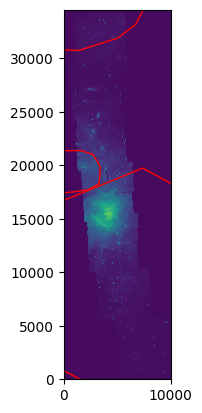

In [324]:
fig, ax = plt.subplots()
stretch = AsinhStretch(a=0.005)
norm = ImageNormalize(stretch=stretch, vmin=-1*np.abs(np.min(im))*0.1, vmax=np.max(im)*0.6)
ax.imshow(im, origin='lower', norm=norm)
borders = np.array([])
for j in range(len(bubbles)):
    region = []
    coords = bubbles[j].split(',')[1::]
    for i in range(int(len(coords)/2)):
        #coords[i]
        ra, dec = float(coords[2*i]), float(coords[2*i+1])
        x, y = wcs.all_world2pix(ra, dec, 0)
        region.append((x, y))
    border = patches.Polygon(region, edgecolor='red', facecolor='none')
    ax.add_patch(border)
    borders = np.append(borders, border)

#### NGC 1977 extended 

In [325]:
i_1 = np.array([])
path = borders[0].get_path()
for i in range(len(ra_f2)):
    x_1, y_1 = wcs.all_world2pix(ra_f2[i], dec_f2[i], 0)
    if path.contains_point((x_1, y_1)):
        if ~np.isin(i, i_1):
            i_1 = np.append(i_1, i)
i_1 = np.array(i_1, int)

All YSO

In [326]:
#Contaminants - all survey objects
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_1[np.isin(i_1, i_yso)])

N_cand:  1
N_cont within 200-5000 (before correction):  1.5557142857142858
N_cont within 200-5000:  1.1009316106278217
N_contaminants:  33.0
N_comp:  -0.10093161062782174
CF (28):  -0.0036047003795650623


Protostars

In [327]:
#Contaminants - all survey objects
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_1[np.isin(i_1, i_proto)])

N_cand:  0
N_cont within 200-5000 (before correction):  0.0
N_cont within 200-5000:  0.0
N_contaminants:  0.0
N_comp:  0
CF (1):  0.0


Pre-Main Sequence Stars

In [328]:
#Contaminants - all survey objects
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_1[np.isin(i_1, i_prems)])

N_cand:  1
N_cont within 200-5000 (before correction):  1.5557142857142858
N_cont within 200-5000:  1.1009316106278217
N_contaminants:  33.0
N_comp:  -0.10093161062782174
CF (27):  -0.003738207801030435


#### M43 

In [329]:
i_2 = np.array([])
path = borders[1].get_path()
for i in range(len(ra_f2)):
    x_2, y_2 = wcs.all_world2pix(ra_f2[i], dec_f2[i], 0)
    if path.contains_point((x_2, y_2)):
        if ~np.isin(i, i_2):
            i_2 = np.append(i_2, i)
i_2 = np.array(i_2, int)

In [330]:
#Contaminants - objects only in the selected environment
dmag, R, dist = CF(ra_f2[i_2], dec_f2[i_2], m_f2[i_2], np.where(np.isin(i_2, i_yso))[0])

N_cand:  4
N_cont within 200-5000 (before correction):  2.3571428571428568
N_cont within 200-5000:  1.7105832457055836
N_contaminants:  50.0
N_comp:  2.2894167542944164
CF (42):  0.05450992272129563


All YSO

In [331]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_yso[np.isin(i_yso, i_2)])

N_cand:  4
N_cont within 200-5000 (before correction):  2.451428571428571
N_cont within 200-5000:  1.800740162882923
N_contaminants:  52.0
N_comp:  2.1992598371170766
CF (42):  0.05236332945516849


Note: No protostars

Pre-Main Sequence Stars

In [332]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_prems[np.isin(i_prems, i_2)])

N_cand:  4
N_cont within 200-5000 (before correction):  2.451428571428571
N_cont within 200-5000:  1.800740162882923
N_contaminants:  52.0
N_comp:  2.1992598371170766
CF (42):  0.05236332945516849


#### Orion nebula extended 

In [333]:
i_3 = np.array([])
path = borders[2].get_path()
for i in range(len(ra_f2)):
    x_3, y_3 = wcs.all_world2pix(ra_f2[i], dec_f2[i], 0)
    if path.contains_point((x_3, y_3)):
        if ~np.isin(i, i_3):
            i_3 = np.append(i_3, i)
i_3 = np.array(i_3, int)

All YSO

In [334]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_yso[np.isin(i_yso, i_3)])

N_cand:  63
N_cont within 200-5000 (before correction):  28.427142857142854
N_cont within 200-5000:  24.35613914908822
N_contaminants:  603.0
N_comp:  38.643860850911764
CF (422):  0.0915731299784639


Protostars

In [335]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_proto[np.isin(i_proto, i_3)])

N_cand:  5
N_cont within 200-5000 (before correction):  1.98
N_cont within 200-5000:  1.816981199361014
N_contaminants:  42.0
N_comp:  3.183018800638986
CF (32):  0.09946933751996831


Pre-Main Sequence Stars

In [336]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_prems[np.isin(i_prems, i_3)])

N_cand:  58
N_cont within 200-5000 (before correction):  26.447142857142858
N_cont within 200-5000:  22.53915794972721
N_contaminants:  561.0
N_comp:  35.46084205027279
CF (390):  0.09092523602634048
